# Exploration 
Purpose of this notebook is to explore the calculations needed for the final backtest and to document the code needed for the backtest

### contents
1) Calculation of the eigenportfolio's
2) Creating stationary time series 
3) fitting Ornstein-Uhlenbeck model to the data
4) Generating Buy and sell signals
5) **(optional)** testing the genetic algorithm

### 0) Imports and other preparations

In [2]:
LOOKBACK_PERIOD = 192 #2 days is the total lookback period 

In [3]:
from binance import Client
import pandas as pd
import datetime as dt
import numpy as np
import json
from os.path import exists
from tqdm import trange, tqdm
from numpy.linalg import eig, norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.optimize as so
import seaborn as sns

In [4]:
pct_ret = pd.read_csv('pct_returns.csv').set_index('close_time').head(LOOKBACK_PERIOD)
log_ret = pd.read_csv('log_returns.csv').set_index('close_time').head(LOOKBACK_PERIOD)

In [5]:
std_ret = ((pct_ret - pct_ret.mean())/ pct_ret.std())

### 1) Calculation of the eigenportfolio's

##### I will calculate this based on the final 1000 datapoints because this will be the same timeframe i will use in the backtest

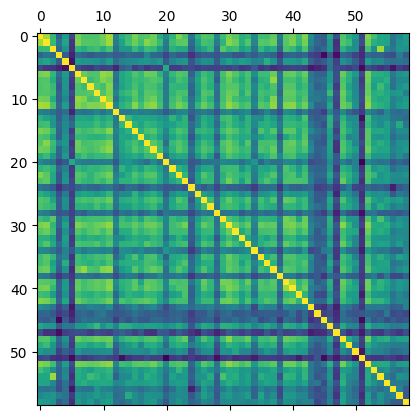

In [6]:
corr = std_ret.corr()
plt.matshow(corr)
plt.show()


In [7]:
corr_matrix = corr.to_numpy()
values, vectors = eig(corr_matrix)

##### below is a scree plot which shows that we can clearly distinguish an underlying factor representing the market using the first eigenvector

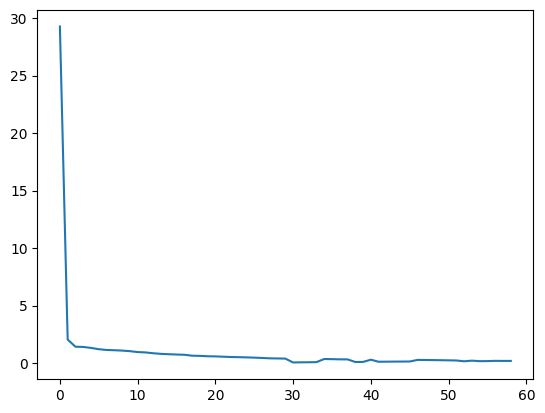

In [8]:
plt.plot(values)

Eigenportfolio returns are calclated as
$ F_{jk} = \displaystyle\sum_{i=1}^N{\frac{v_j^{(j)}}{\sigma_i} \cdot R_{ik}}$


In [145]:
#calculation of the portfolio
eigenportfolio = vectors / pct_ret.std().values[:,None]
#normalise the weights
eigenportfolio = eigenportfolio / norm(eigenportfolio,1)

In [146]:
ret_eigenportfolio = pct_ret.dot(eigenportfolio)

In [300]:
pct_ret.iloc[1].dot(eigenportfolio[:,1])

0.0030390913561487215

##### Plotting the returns of the first eigenportfolio against bitcoin clearly shows how correlated both are

In [147]:
compared_asset = 'DOGEUSDT'

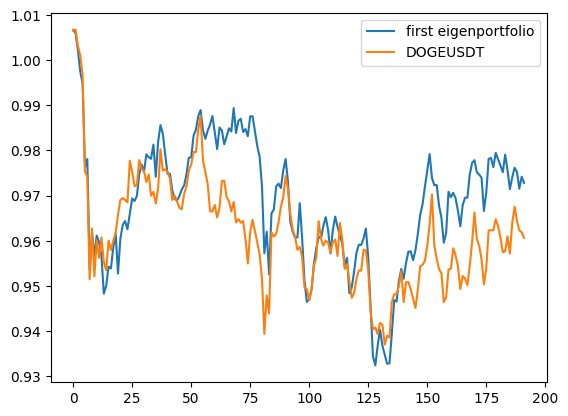

In [148]:
ret_asset = log_ret[compared_asset].cumsum().apply(np.exp)
plt.plot((ret_eigenportfolio+1).cumprod().values[:,0],label="first eigenportfolio")
plt.plot(ret_asset.values,label=compared_asset)
plt.legend()

### 2) Creating stationary time series 

based on the paper by Avalanda and Lee (2008) I will use the following SDE to model the asset returns:
$$ \frac{dS_i(t)}{S_i(t)} = \alpha_i dt + \displaystyle\sum_{i=1}^N{\beta_{ij}\frac{dI_j(t)}{I_j(t)}} + dX_i(t) $$

where the term $\displaystyle\sum_{i=1}^N{\beta_{ij}\frac{dI_j(t)}{I_j(t)}}$ represents the systematic component, in this model the eigenportfolio's are used

the idiosyncratic component is $\alpha_i dt + dX_i(t)$


in this section i will explore ways to find the appropriate Beta's and to isolate the idiosyncratic component of the asset returns

The number of eigenportfolio's I will use to model the systematic component will be chosen such that 55% of the variance can be captured by the eigenportfolio's 
this way i don't use a fixed number of eigenvalues 

##### An obvious way is to use linear regression

In [149]:
values[0:7].sum() / values.sum()

0.6406765124897649

In [150]:
amount_of_portfolios = 3

4 eigenportfolio's should be enough to model 60% of the variance in the returns

the intercept appeared to be a very important addition because some drift does exist, in the model this is the $\alpha_idt$ component and is very kappach needed to accurately isolate the $dX_i(t)$ component

[[ 0.74102514 -0.06229111 -0.06963077]]
0.0


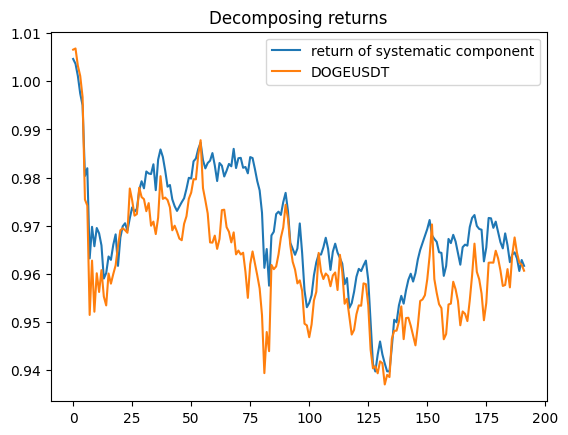

In [302]:
regr = LinearRegression(fit_intercept=False)
y = std_ret[compared_asset].values.reshape((len(pct_ret), 1))
x = ((ret_eigenportfolio - ret_eigenportfolio.mean())/ret_eigenportfolio.std()).values[:,0:amount_of_portfolios]
regr.fit(x,y)
betas = regr.coef_
alpha = regr.intercept_
print(betas)
print(alpha)

plt.plot((regr.predict(x)*pct_ret[compared_asset].std() + pct_ret[compared_asset].mean() +1).cumprod(),label='return of systematic component')
plt.plot(log_ret[compared_asset].cumsum().apply(np.exp).values, label=compared_asset)
plt.legend()
plt.title('Decomposing returns')
plt.savefig('returns_decomp.png')

[[ 0.75672295 -0.23496893 -0.31278853]]
0.0


Text(0.5, 1.0, 'not accounting for drift')

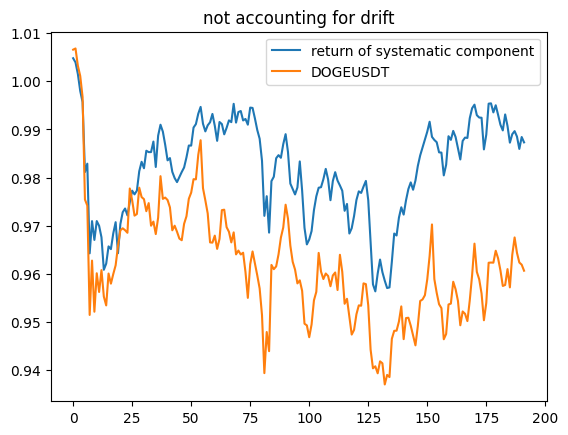

In [271]:
regr = LinearRegression(fit_intercept=False)
y = pct_ret[compared_asset].values.reshape((len(pct_ret), 1))
x = (ret_eigenportfolio).values[:,0:amount_of_portfolios]
regr.fit(x,y)
betas = regr.coef_
alpha = regr.intercept_
print(betas)
print(alpha)

plt.plot((regr.predict(x)+1).cumprod(),label='return of systematic component')
plt.plot(log_ret[compared_asset].cumsum().apply(np.exp).values, label=compared_asset)
plt.legend()
plt.title('not accounting for drift')

In [272]:
alpha = -0.00013843

Now I shall subtract the systematic component of the returns of bitcoin and plot the idosyncratic returns

In [273]:
pct_ret_res = (pct_ret[compared_asset].values - (regr.predict(x)).flatten())

Text(0.5, 1.0, '$\\alpha_idt + X_i(t)$ of asset model')

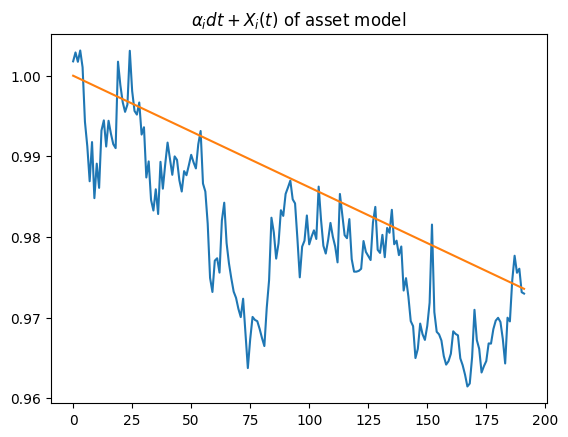

In [274]:
Xi = (pct_ret_res+1).cumprod()
plt.plot(Xi)
plt.plot(alpha * np.array(range(0,LOOKBACK_PERIOD)) + 1)
plt.title(r'$\alpha_idt + X_i(t)$ of asset model')

next up I will fit the OU-model to the data isolated above and judge the goodness of fit

### 3) Fitting Ornstein-Uhlenbeck model to the data

In the paper by Avalanda and Lee (2008) the idiosyncratic component is assumed to be an Ornstein-Uhlenbeck process which can be modelled by the following SDE:
$dX_i(t) = \kappa_i(m_i - X_i(t))dt + \sigma_idW_i(t)$

This process is stationary and auto-regressive with lag 1
with $E[dX_i(t)|X_i(s), s \leq t] = \kappa_i(m_i - X_i(t))dt$

meaning the expected returns are positive or negative according to the sign of $m_i - X_i(t)$

Next up I wil fit the OU-model to our data incorporating the drift and constructing the s-score used in the paper

I will use 2 methods:
1) One based on linear regression using a method used by Avalanda and Lee (2008)
2) MLE discussed in the paper by Leung and LI (2015)

then i will compare both methods both on speed and accuracy

##### 3.1) LR fitting

Assuming that the parameters of the OU-model are constant the model can discretized using following formula
$$X_i(t_{0} + \Delta t) = e^{- \kappa_i \Delta t} X_i(t_{0}) + m_i(1-e^{- \kappa_i \Delta t}) + \sigma_i \int_{t_{0}}^{t_{0}+\Delta t}{e^{- \kappa_i (t_{0}+\Delta t-s)}dW_i(s)}$$

Letting $\Delta t$ tend to infinity, the probability distribution of the process is normal with $E[X_i(t)] = m_i$ and $Var[X_i(t)] = \frac{\sigma_i^2}{2\kappa_i}$

using linear regression i try to fit the following discrete model
$X_{i+1} = a+ bX_{i} + \zeta_i$

from these predicted parameters i can find the OU-model parameters using the following equations:

$b = e^{- \kappa_i \Delta t}$

$m_i = a / (1-b)$]

$\sigma_i = \sqrt{Var[X_i(t)]\cdot2\kappa_i}$

$\sigma_{eq,i} = {\sigma_i}/{\sqrt{2\kappa_i}}$

$\tau_i = 1 / \kappa_i$ is the average time of reversal 
and this is a paramete which can be used as a cutoff for when to trade

##### 3.2) MLE fitting 

This method for fitting the data is adapted from the paper: Optimal Mean Reversion Trading with transaction costs and stop-loss exit by Leung and Li (2008)

They propose fitting the Ornstei-Uhlenbeck model using a MLE method using the following Conditional probability density:
$$f^{OU}(x_i|x_{i-1};m_i, \kappa, \sigma) = \frac{1}{\sqrt{2\pi \tilde{\sigma}^2}} \exp(-\frac{(x_i - x_{i-1}e^{-\kappa \Delta t}-\theta (1- e^{-\kappa \Delta t}))^2}{2 \tilde{\sigma}^2})$$

with the constant $\tilde{\sigma}^2 = \sigma^2 (1-e^{-2\kappa \Delta t})/2\kappa$

Using the observed values $(x_i)_{i=1,...,n}$ we can maximise the average log-likelihood defined by:

$$\ell(\theta, \kappa, \sigma|x_{0},x_{1},....,x_{n}) := \frac{1}{n} \displaystyle\sum_{i=1}^n{ln(f^{OU}(x_i|x_{i-1};\theta, \kappa, \sigma))} 
=\frac{1}{2}ln(2\pi) - ln(\tilde{\sigma}) - \frac{1}{2n\tilde{\sigma}^2} \displaystyle\sum_{i=1}^n{|(x_i - x_{i-1}e^{-\kappa \Delta t}-\theta (1- e^{-\kappa \Delta t}))|^2}$$

In [284]:
regr = LinearRegression(fit_intercept=True)
y = pct_ret[compared_asset].values.reshape((len(pct_ret), 1))
x = (ret_eigenportfolio).values[:,0:amount_of_portfolios]
regr.fit(x,y)
betas = regr.coef_
alpha = regr.intercept_
print(betas)
print(alpha)
pct_ret_res = (pct_ret[compared_asset].values - (regr.predict(x)).flatten())
Xi = (pct_ret_res+1).cumprod()

[[ 0.75596306 -0.24046797 -0.32203464]]
[-0.00013843]


In [285]:
kappa, m, sigma, sigma_eq = estimate_coefficients_MLE(Xi, 1/LOOKBACK_PERIOD, tol=1e-10)
kappa, m, sigma, sigma_eq

(29.98737830403139,
 0.9923205752429809,
 0.047207376178871836,
 0.006095728500730512)

In [286]:
kappa, m, sigma, sigma_eq = estimate_coefficients_LR(Xi, LOOKBACK_PERIOD)
kappa, m, sigma, sigma_eq

(29.988112731707997,
 0.9923206166266042,
 0.04793195540431893,
 0.006189215170250452)

Both methods seem to give essentially the same output, therefore I will investigate wich has the fastest runtime and with that one i will continue in the full backtest

In [263]:
%timeit estimate_coefficients_MLE(Xi, 1/LOOKBACK_PERIOD, tol=1e-10)

296 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit estimate_coefficients_LR(Xi, 1/LOOKBACK_PERIOD)

998 µs ± 177 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


linear regression technique seems to be a signifcant 350 times speedup so I will continue with that method 

### 4) Generating buy-sell signals

##### 4.1) Calculating s-scores 

S-score is a standardised value used in the strategy outlined in the paper by avalanda

$s_i = \frac{X_i(t)-m_i}{\sigma_{eq,i}}$

which can be adjusted to account for drift which i will do as well

$s_{mod,i} = s_i - \alpha_i / (\kappa_i \sigma_{eq,i})$

The drift can be interpreted as the slope of the 1000 moving average, we therefore have a built in momentum strategy in this indicator

In [291]:
s_score = (Xi - m ) / sigma_eq
s_score_mod = s_score - (alpha * LOOKBACK_PERIOD / (kappa*sigma_eq))*5

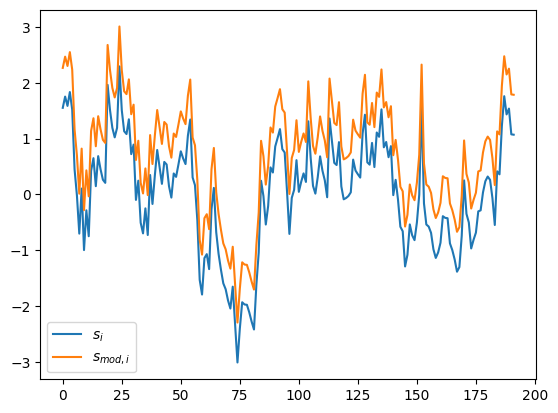

In [303]:
plt.plot(s_score,label='$s_i$')
plt.plot(s_score_mod,label='$s_{mod,i}$')
plt.legend()
plt.savefig('s_score.png')

Text(0.5, 1.0, 'pdf of the s-scores')

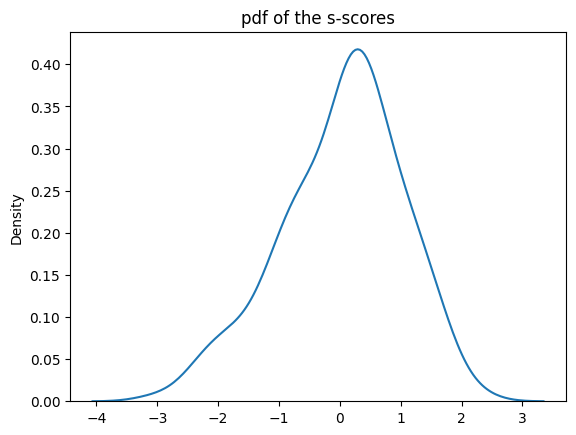

In [290]:
ax = sns.kdeplot(data=s_score)
plt.title('pdf of the s-scores')


##### 4.2) Using fixed cutoff rules.

Significant drawback of using this method for generating buy and sell signals is that a arbitrary cuttoff will be used when deciding when to buy or sell in the paper (Avalanda 2008) the following rule is used:

- buy to open if $s_i < -1.25$
- sell to close if $s_i > -0.5$


- sell to open if $s_i > 1.25$
- buy to open if $s_i < -0.75$

I could however try to optimise these 4 parameters for my dataset using a genetic algorithm for example

##### 4.3) Using dynamic cutoff rules.

##### 4.4) Using a machine learning model



Using a neural network I will try to predict when the s-score will most likely significantly move up-down towards it's mean:

Model:
- Inputs: $ \kappa , \sigma $, S-scores, number of eigenportfolios used
- Target: 2 neurons: signicantly up (+2 s-scores), significantly down (-2 s-scores)

In the original paper the authors used a cutoff based on the size of kappa, this cutoff was derived somewhat arbitrary but I will include it as a feature. 

I will include $\sigma$ because it might be an important factor because ??

Strategy:
I will define a cutoff 5% for example and when the model is 95% certain of a mean reversion I can enter the trade

Data: 
I will use 40% of the data to fit the neural network on for all the pairs

- Calculate the eigenportfolio accounting for 55% of the variance at time t based on data of [t-LOOKBACK_PERIOD, t] do this again at time t+LOOKBACK_PERIOD
- Create the stationary time series at time t based on the current eigenportfolio
- Fit OU-model at time t on stationary time on data of [t-LOOKBACK_PERIOD, t], saving the goodness-of-fit on this timeframe and comparing it to the goodness-of-fit on the stationary time series of time on data of [t, t+LOOKBACK_PERIOD] could give an indication of how well a fitted OU-model fits future data
- Save all the OU-model parameters so they can be used for training the neural network
- Calculate the s-scores
- Create target features: 1 if s-score is signicantly up (+2 s-scores) / 0 if not , 1 if s-score is signicantly down (-2 s-scores) / 0 if not

Steps:
- create features
- check robustness in time of the OU-model
- fit the neural network
- check performance

In [29]:
PRED_HORIZON = 10 # I will use a prediction horizon of approximately 2,5 hours
EIGENPORTFOLIO_CUTOFF = 0.55
SIGNIFICANCE_CUTOFF = 2
IN_SAMPLE = 0.2

In [30]:
pd.Series(s_score).rolling(PRED_HORIZON).min().shift(-PRED_HORIZON).dropna().values.size

182

Text(0, 0.5, '$s_{t+10}-s_t$')

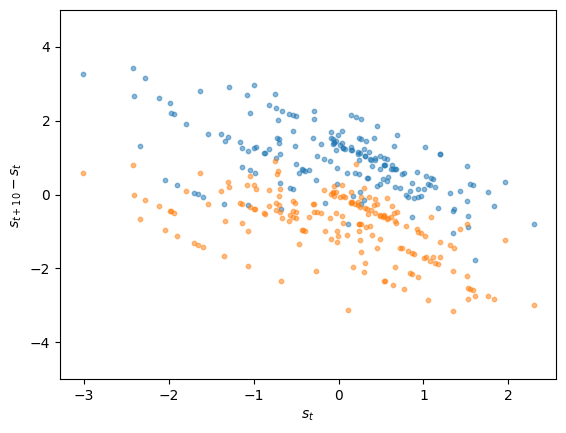

In [31]:
target_up = (pd.Series(s_score).rolling(PRED_HORIZON).max().shift(-PRED_HORIZON).dropna().values) - s_score[:-PRED_HORIZON]
plt.scatter(s_score[:-PRED_HORIZON], target_up,s=10,alpha=0.5)

target_down = (pd.Series(s_score).rolling(PRED_HORIZON).min().shift(-PRED_HORIZON).dropna().values) - s_score[:-PRED_HORIZON]
plt.scatter(s_score[:-PRED_HORIZON], target_down,s=10,alpha=0.5)

plt.ylim(-5,5)
plt.xlabel('$s_t$')
plt.ylabel('$s_{t+10}-s_t$')

the figure above shows as expected a negative relation

##### 4.2.1) Creating the features



Before I start i need to create a standardised returns dataset to construct this i use the same LOOKBACK_PERIOD windows as to avoid forward looking bias

In [81]:
%load_ext autoreload
from SA_OU_helpers import *
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
goodness_of_fit, R2_training_all_epochs, R2_forward_all_epochs, returns_res_forward, returns_res_training, Xi_training, Xi_forward, OU_params, eig_portf, s_score_training, s_score_forward,betas_all_epochs = prepare_data('pct_returns.csv', 'log_returns.csv', LOOKBACK_PERIOD, EIGENPORTFOLIO_CUTOFF)

100%|██████████| 267/267 [00:13<00:00, 19.20it/s]


Text(0.5, 1.0, 'number of eigenportfolios needed for threshhold')

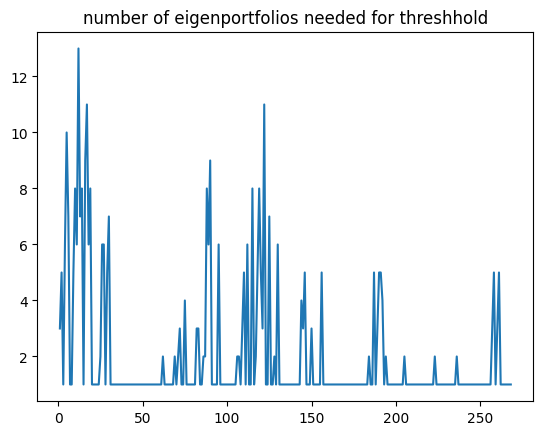

In [83]:
plt.plot(eig_portf.num_of_portfolios)
plt.title('number of eigenportfolios needed for threshhold')

This plot paints a worrying picture because it seems like the variance explained by the eigenvectors tends to vary quite significantly from epoch to epoch

might be worth investigating which variables correlate with this

The stationary time series fitted on data from time t-Lookback until time t

this model will be used to create the forward time series from time t until t+1

might be interesting to save the goodness-of-fit for the training and forward looking data and comparing the performance

Text(0, 0.5, 'R2_of_forward')

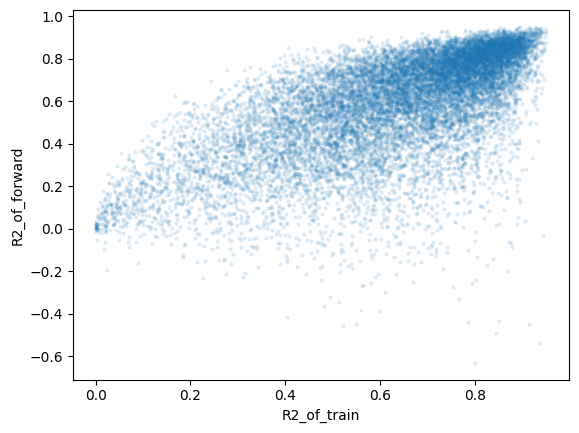

In [84]:
plt.scatter(goodness_of_fit['R2_of_train'],goodness_of_fit['R2_of_forward'],alpha=0.1, s=4)
plt.xlabel('R2_of_train')
plt.ylabel('R2_of_forward')

The above scatterplot is a very good signal showing that the model performs as well in most cases on the forward data as on the training data

Text(0.5, 1.0, '$X_i(t)$ for BTCUSDT forward data')

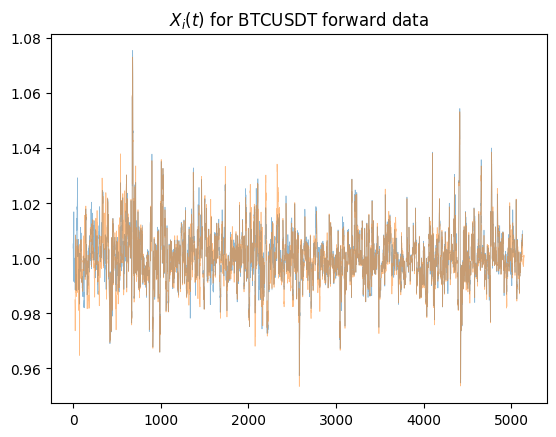

In [85]:
plt.plot(Xi_training.BTCUSDT.iloc[::10].values,linewidth=0.5,alpha=0.5)
plt.plot(Xi_forward.BTCUSDT.iloc[::10].values,linewidth=0.5,alpha=0.5)
plt.title('$X_i(t)$ for BTCUSDT forward data')


having plotted the above chart it seems like everything is still looking very good

Next up i'm going to calculate the forward s-scores based on OU-parameters calculated with training data
$s_i = \frac{X_i(t)-m_i}{\sigma_{eq,i}}$

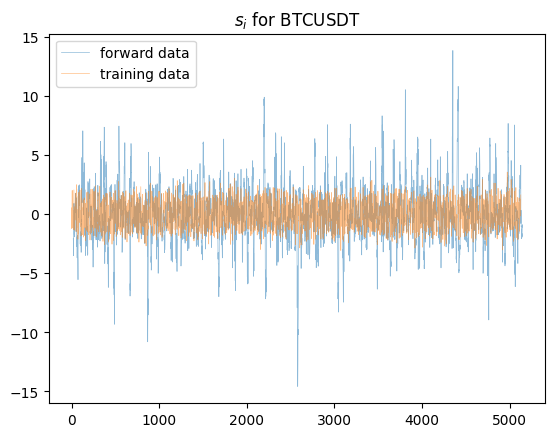

In [86]:
plt.plot(s_score_forward.BTCUSDT.iloc[::10].values,linewidth=0.5,alpha=0.5,label='forward data')
plt.plot(s_score_training.BTCUSDT.iloc[::10].values,linewidth=0.5,alpha=0.5,label='training data')
plt.title('$s_i$ for BTCUSDT')
plt.legend()

s-scores are a lot more volatile on forward data than for training data this could be a problem

I'm using the following definitions for significantly down and up:

down if: $min(s_{t+1},...,s_{t+10}) - s_t < -k$

up if: $max(s_{t+1},...,s_{t+10}) - s_t > k$

In [236]:
#calculate the change in s-scores
s_score_forward_change = (s_score_forward.shift(-PRED_HORIZON) - s_score_forward)

s_score_forward_up = (s_score_forward).rolling(PRED_HORIZON).max().shift(-PRED_HORIZON) - s_score_forward
s_score_forward_down = (s_score_forward).rolling(PRED_HORIZON).min().shift(-PRED_HORIZON) - s_score_forward

#create target variables
score_sign_up = pd.DataFrame(index = s_score_forward_change.index, columns=s_score_forward_change.columns)
score_sign_up.iloc[:,:] = np.where(s_score_forward_up > SIGNIFICANCE_CUTOFF, 1,0)

score_sign_down = pd.DataFrame(index = s_score_forward_change.index, columns=s_score_forward_change.columns)
score_sign_down.iloc[:,:] = np.where(s_score_forward_down < -SIGNIFICANCE_CUTOFF, 1,0)

finally i'm going to create the trainings dataset i need

In [254]:
output_path='features.csv'
for epoch in tqdm(range(1,epochs-1)):
    for asset in s_score_forward.columns:
        #selecting the appropriate data
        start_range_forward = (epoch)*LOOKBACK_PERIOD #time t
        end_range_forward = (epoch+1)*LOOKBACK_PERIOD #time t+L

        #get the OU parameters of the asset for this epoch
        params_epoch = OU_params.loc[epoch,asset]
        kappa_epoch = params_epoch[0]
        sigma_epoch = params_epoch[2]

        R2_training = R2_training_all_epochs.loc[epoch,asset]

        #get the amount of eigenportfolio's necessary in this epoch, is a measure of how in sync the market was
        num_portf_epoch = eig_portf.loc[epoch,'num_of_portfolios']
        
        #get the s-scors for the epoch
        data_epoch = pd.DataFrame(s_score_forward.iloc[start_range_forward:end_range_forward,s_score_forward.columns.get_loc(asset)])
        data_epoch = data_epoch.rename({asset:'s_score'},axis=1)

        #construct the features for this asset and epoch
        data_epoch['kappa'] = kappa_epoch
        data_epoch['sigma'] = sigma_epoch
        data_epoch['num_portf'] = num_portf_epoch
        data_epoch['R2'] = R2_training
        data_epoch['asset'] = asset

        data_epoch['up'] = score_sign_up.iloc[start_range_forward:end_range_forward,s_score_forward.columns.get_loc(asset)].values
        data_epoch['down'] = score_sign_down.iloc[start_range_forward:end_range_forward,s_score_forward.columns.get_loc(asset)].values

        #save all these features in one dataframe
        data_epoch.to_csv(output_path, mode='a', header=not os.path.exists(output_path))

100%|██████████| 267/267 [02:14<00:00,  1.99it/s]


In [260]:
features = pd.read_csv(output_path)
features = features.rename({'Unnamed: 0':'DateTime'},axis = 1)
features = features.set_index('DateTime')

By selecting on R2 and on kappa I can make sure i only try to model the well fitted models

In [445]:
R2_THRESH = 0
KAPPA_THRESH = 0

In [446]:
cleaned_features_insample = features.iloc[:int(len(features)*IN_SAMPLE)]
cleaned_features_insample = cleaned_features_insample[(cleaned_features_insample.R2 > R2_THRESH)&(cleaned_features_insample.kappa > KAPPA_THRESH)]

cleaned_features_outsample = features.iloc[int(len(features)*IN_SAMPLE):]
cleaned_features_outsample = cleaned_features_outsample[(cleaned_features_outsample.R2 > R2_THRESH)&(cleaned_features_outsample.kappa > KAPPA_THRESH)]

In [447]:
def filter(row):
    if row.up == 1 & row.down == 1:
        return 'vol'
    elif row.up == 1:
        return 'up'
    elif row.down == 1:
        return 'down'
    else: 
        return 'side'

cleaned_features_insample['target'] = cleaned_features_insample.apply(lambda row: filter(row),axis=1)
cleaned_features_outsample['target'] = cleaned_features_outsample.apply(lambda row: filter(row),axis=1)

cleaned_features_insample['feat'] = cleaned_features_insample.s_score * cleaned_features_insample.kappa
cleaned_features_outsample['feat'] = cleaned_features_outsample.s_score * cleaned_features_outsample.kappa

In [448]:
cleaned_features_outsample.target.value_counts()

side    1693407
up       358439
down     332126
vol       35689
Name: target, dtype: int64

##### 4.2.2) Training the model



In [87]:
from sklearn.linear_model import LogisticRegression 
softmax_reg = LogisticRegression(multi_class="multinomial", solver='lbfgs',C=10)

In [450]:
x_training = cleaned_features_insample[['s_score','feat']].values
y_training = cleaned_features_insample.target.values

x_test = cleaned_features_outsample[['s_score','feat']].values
y_test = cleaned_features_outsample.target.values

In [451]:
softmax_reg.fit(x_training, y_training)

/Users/quintengeerts/Desktop/SA-OU Model/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10, multi_class='multinomial')

##### 4.2.3) Evaluating the model



In [452]:
import sklearn.metrics as metrics

In [453]:
y_pred_insample = softmax_reg.predict(x_training)
y_pred_outsample = softmax_reg.predict(x_test)

In [454]:
pd.Series(y_pred_outsample).value_counts()

side    2381837
down      34154
up         3588
vol          82
dtype: int64

I want to know how often it doesn't go up even though it is predicted

In [455]:
check_train = pd.DataFrame()
check_train['pred'] = y_pred_insample
check_train['real'] = y_training

print('when predicting up')
print(check_train[check_train.pred == 'up'].real.value_counts() / len(check_train[check_train.pred == 'up']))
print('\nwhen predicting down')
check_train[check_train.pred == 'down'].real.value_counts() / len(check_train[check_train.pred == 'down'])

when predicting up
up      0.451271
down    0.279661
vol     0.151130
side    0.117938
Name: real, dtype: float64

when predicting down


down    0.523545
vol     0.211389
up      0.203367
side    0.061698
Name: real, dtype: float64

In [456]:
check_train = pd.DataFrame()
check_train['pred'] = y_pred_outsample
check_train['real'] = y_test

print('when predicting up')
print(check_train[check_train.pred == 'up'].real.value_counts() / len(check_train[check_train.pred == 'up']))
print('\nwhen predicting down')
check_train[check_train.pred == 'down'].real.value_counts() / len(check_train[check_train.pred == 'down'])

when predicting up
up      0.364827
down    0.317447
vol     0.220178
side    0.097547
Name: real, dtype: float64

when predicting down


down    0.517890
up      0.205218
vol     0.180360
side    0.096533
Name: real, dtype: float64

In [458]:
cleaned_features_outsample['pred'] = y_pred_outsample

In [465]:
cleaned_features_outsample[cleaned_features_outsample.asset == 'BTCUSDT'].pred.value_counts()

side    40896
Name: pred, dtype: int64

### 6) preparations for using a genetic algortithm for optimising the strategy

Used parameters are:
- lookback period
- 4 entry and exit points
- stop loss
- (max holding time) could be replaced with lookback period 